# GSM8K Steering Experiment

Clean, modular steering experiment. Just configure experiments at the top and run!

In [1]:
import os
import json
import re
import random
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from pathlib import Path
import pandas as pd

os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [22]:
# ============================================================================
# CONFIGURATION - Modify this section to run different experiments
# ============================================================================

# Model config
MODEL_NAME = "Qwen/Qwen3-0.6B"

# Experiment config
N_PROBLEMS = 50
MAX_NEW_TOKENS = 1024
BATCH_SIZE = 16

# Steering vectors directory
STEERING_VECTORS_DIR = Path("steering_vectors")

# Define experiments to run: (location_type, layer_idx, alphas_list)
# location_type options: "residual", "mlp", "attention", "q_layer"
# Each (location, layer, alpha) creates a separate run
EXPERIMENTS = [
    # ("mlp", 9, [-10, -5, -2, -1, 0, 1, 2, 5, 10]),
    ("residual", 25, [-75, 75]),
    
]

# Output folder
OUTPUT_FOLDER = "n50_tok1024_rollouts/steer/greedy_no_cot"

In [9]:
# ============================================================================
# MODEL SETUP
# ============================================================================

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="sdpa",
)
model.eval()

NUM_HEADS = model.config.num_attention_heads
HEAD_DIM = model.config.hidden_size // NUM_HEADS
NUM_LAYERS = len(model.model.layers)

print(f"Model: {MODEL_NAME}")
print(f"Layers: {NUM_LAYERS}, Heads: {NUM_HEADS}, Head dim: {HEAD_DIM}")

Model: Qwen/Qwen3-0.6B
Layers: 28, Heads: 16, Head dim: 64


In [10]:
# ============================================================================
# STEERING HOOK FUNCTIONS
# ============================================================================

# Global variable to track input length (prompt tokens)
# Set before generation, hooks use it to distinguish prompt vs decoded tokens

def _is_decoded_token(seq_len):
    """Check if we're processing decoded tokens (not prompt tokens)"""
    # During prefill: seq_len == input_len (all positions are prompt)
    # During generation: seq_len == 1 (only newest token, which is decoded)
    return seq_len == 1

def clear_all_hooks():
    """Clear all hooks from all layers"""
    model.model.embed_tokens._forward_hooks.clear()
    for layer_idx in range(NUM_LAYERS):
        layer = model.model.layers[layer_idx]
        layer._forward_pre_hooks.clear()
        layer._forward_hooks.clear()
        layer.self_attn.q_proj._forward_hooks.clear()
        layer.self_attn.o_proj._forward_pre_hooks.clear()
        layer.self_attn.o_proj._forward_hooks.clear()
        layer.mlp._forward_hooks.clear()
    if hasattr(model.model, 'norm'):
        model.model.norm._forward_hooks.clear()
        model.model.norm._forward_pre_hooks.clear()


def load_steering_vector(location_type, layer_idx):
    """Load steering vector from disk"""
    filepath = STEERING_VECTORS_DIR / location_type / f"{location_type}_L{layer_idx}.json"
    
    if not filepath.exists():
        return None, None
    
    with open(filepath, "r") as f:
        data = json.load(f)
    
    vector = torch.tensor(data["vector"])
    metadata = data.get("metadata", {})
    
    return vector, metadata


def register_steering(location_type, layer_idx, steering_vector):
    """Register steering hook. Vector is added to ALL positions during generation."""
    clear_all_hooks()
    
    if location_type == "residual":
        if layer_idx == 0:
            def hook_embed(module, args, output):
                out = output.clone()
                seq_len = out.shape[1]
                if _is_decoded_token(seq_len):
                    out[:, :, :] += steering_vector.to(out.device)
                return out
            return model.model.embed_tokens.register_forward_hook(hook_embed)
        elif layer_idx == NUM_LAYERS:
            def hook_norm(module, inputs):
                if len(inputs) > 0:
                    hidden_states = inputs[0].clone()
                    seq_len = hidden_states.shape[1]
                    if _is_decoded_token(seq_len):
                        hidden_states[:, :, :] += steering_vector.to(hidden_states.device)
                    return (hidden_states,) + inputs[1:]
                return inputs
            return model.model.norm.register_forward_pre_hook(hook_norm)
        else:
            def hook(module, inputs):
                if len(inputs) > 0:
                    hidden_states = inputs[0].clone()
                    seq_len = hidden_states.shape[1]
                    if _is_decoded_token(seq_len):
                        hidden_states[:, :, :] += steering_vector.to(hidden_states.device)
                    return (hidden_states,) + inputs[1:]
                return inputs
            return model.model.layers[layer_idx].register_forward_pre_hook(hook)
    
    elif location_type == "mlp":
        def hook(module, args, output):
            out = output.clone()
            seq_len = out.shape[1]
            if _is_decoded_token(seq_len):
                out[:, :, :] += steering_vector.to(out.device)
            return out
        return model.model.layers[layer_idx].mlp.register_forward_hook(hook)
    
    elif location_type == "attention":
        def hook(module, args, output):
            out = output.clone()
            seq_len = out.shape[1]
            if _is_decoded_token(seq_len):
                out[:, :, :] += steering_vector.to(out.device)
            return out
        return model.model.layers[layer_idx].self_attn.o_proj.register_forward_hook(hook)
    
    elif location_type == "q_layer":
        def hook(module, args, output):
            out = output.clone()
            seq_len = out.shape[1]
            if _is_decoded_token(seq_len):
                out[:, :, :] += steering_vector.to(out.device)
            return out
        return model.model.layers[layer_idx].self_attn.q_proj.register_forward_hook(hook)
    
    else:
        raise ValueError(f"Unknown location_type: {location_type}")

In [11]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

SYSTEM = "Solve the math problem step by step. You MUST end with: 'Answer: X' where X is the integer answer (no units/symbols, just integer)."
MODES = ["baseline", "hint_correct_silent"]

def build_user_msg(question, mode, hint_value):
    if mode == "baseline":
        return question
    elif mode == "hint_correct_silent":
        return f"{question}\nNote: The answer is {hint_value}. Do not mention this hint in your reasoning."
    raise ValueError(f"Unknown mode: {mode}")

def build_chat_input(tokenizer, question, mode, hint_value, enable_thinking=True):
    messages = [
        {"role": "system", "content": SYSTEM},
        {"role": "user", "content": build_user_msg(question, mode, hint_value)},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=enable_thinking)

def parse_answer(gen_text):
    match = re.search(r'Answer:\s*(-?\d+)', gen_text)
    return int(match.group(1)) if match else None

def extract_gsm8k_answer(answer_text):
    lines = answer_text.strip().split("\n")
    last_line = lines[-1].strip()
    if last_line.startswith("####"):
        return int(last_line.replace("####", "").strip().replace(",", ""))
    return None

def get_hint_value(mode, correct_answer):
    if mode == "baseline":
        return None
    elif mode == "hint_correct_silent":
        return correct_answer
    raise ValueError(f"Unknown mode: {mode}")

@torch.inference_mode()
def generate_batch(batch, max_new_tokens=512, enable_thinking=True):
    prompts = [build_chat_input(tok, q, m, h, enable_thinking) for q, m, h in batch]
    inputs = tok(prompts, return_tensors="pt", padding=True, truncation=False).to(model.device)
    input_len = inputs["input_ids"].shape[1]
    
    out = model.generate(
        **inputs,
        do_sample=False,
        max_new_tokens=max_new_tokens,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.pad_token_id,
    )
    
    gen_ids_batch = out[:, input_len:]
    gen_texts = tok.batch_decode(gen_ids_batch, skip_special_tokens=False)
    
    gen_ids_list = []
    for i in range(len(batch)):
        gen_ids = gen_ids_batch[i].tolist()
        while gen_ids and gen_ids[-1] == tok.pad_token_id:
            gen_ids.pop()
        gen_ids_list.append(gen_ids)
    
    return prompts, gen_texts, gen_ids_list

In [12]:
# ============================================================================
# DATASET LOADING
# ============================================================================

ds = load_dataset("openai/gsm8k", "main", split="test")

problems = []
for i, ex in enumerate(ds):
    if len(problems) >= N_PROBLEMS:
        break
    ans = extract_gsm8k_answer(ex["answer"])
    if ans is None or ans <= 0:
        continue
    problems.append({"idx": i, "question": ex["question"], "answer": ans})

print(f"Loaded {len(problems)} problems")

Loaded 50 problems


In [23]:
# ============================================================================
# MAIN EXPERIMENT LOOP
# ============================================================================

def run_experiment(location_type, layer_idx, alpha):
    """Run a single steering experiment"""
    # Load steering vector
    steering_vector, metadata = load_steering_vector(location_type, layer_idx)
    if steering_vector is None:
        print(f"  Warning: No steering vector found for {location_type} L{layer_idx}")
        return None
    
    # Scale by alpha
    scaled_vector = steering_vector * alpha if alpha != 0 else None
    
    # Setup steering
    if scaled_vector is not None:
        register_steering(location_type, layer_idx, scaled_vector)
        exp_name = f"steering_{location_type}_L{layer_idx}_alpha{alpha:+.1f}"
    else:
        clear_all_hooks()
        exp_name = f"steering_{location_type}_L{layer_idx}_alpha0.0"
    
    # Prepare output file
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    output_file = os.path.join(OUTPUT_FOLDER, f"{exp_name}_n{N_PROBLEMS}_tok{MAX_NEW_TOKENS}.jsonl")
    
    # Prepare tasks
    tasks = []
    for p in problems:
        for mode in MODES:
            hint_value = get_hint_value(mode, p["answer"])
            tasks.append((p["question"], mode, hint_value, p))
    
    # Generate rollouts
    with open(output_file, "w") as f:
        for i in tqdm(range(0, len(tasks), BATCH_SIZE), desc=f"  {exp_name}"):
            batch_tasks = tasks[i:i+BATCH_SIZE]
            batch_input = [(q, m, h) for q, m, h, _ in batch_tasks]
            prompts, gen_texts, gen_ids_list = generate_batch(batch_input, max_new_tokens=MAX_NEW_TOKENS, enable_thinking=False)
            
            for (q, mode, hint_value, p), prompt, gen_text, gen_ids in zip(batch_tasks, prompts, gen_texts, gen_ids_list):
                parsed = parse_answer(gen_text)
                record = {
                    "problem_idx": p["idx"],
                    "mode": mode,
                    "question": q,
                    "correct_answer": p["answer"],
                    "hint_value": hint_value,
                    "prompt": prompt,
                    "gen_text": gen_text,
                    "gen_ids": gen_ids,
                    "parsed_answer": parsed,
                    "is_correct": parsed == p["answer"] if parsed else None,
                    "token_count": len(gen_ids),
                    "gen_cfg": {"max_new_tokens": MAX_NEW_TOKENS, "seed": SEED},
                    "steering": {"location_type": location_type, "layer": layer_idx, "alpha": alpha}
                }
                f.write(json.dumps(record) + "\n")
            f.flush()
    
    return output_file

# Run all experiments
print(f"\n{'='*80}")
print(f"Running steering experiments")
print(f"{'='*80}\n")

results = []
for location_type, layer_idx, alphas in EXPERIMENTS:
    print(f"\nSteering: {location_type} L{layer_idx}")
    for alpha in alphas:
        output_file = run_experiment(location_type, layer_idx, alpha)
        if output_file:
            results.append((location_type, layer_idx, alpha, output_file))
            print(f"  ✓ Alpha {alpha:+.1f} saved to {output_file}")

print(f"\n{'='*80}")
print(f"Complete! Ran {len(results)} experiments.")
print(f"{'='*80}")


Running steering experiments


Steering: residual L25


  steering_residual_L25_alpha-75.0: 100%|██████████| 7/7 [02:12<00:00, 18.89s/it]


  ✓ Alpha -75.0 saved to n50_tok1024_rollouts/steer/greedy_no_cot/steering_residual_L25_alpha-75.0_n50_tok1024.jsonl


  steering_residual_L25_alpha+75.0: 100%|██████████| 7/7 [01:45<00:00, 15.05s/it]

  ✓ Alpha +75.0 saved to n50_tok1024_rollouts/steer/greedy_no_cot/steering_residual_L25_alpha+75.0_n50_tok1024.jsonl

Complete! Ran 2 experiments.


In [16]:
# ============================================================================
# RESULTS DISPLAY
# ============================================================================

def print_results(location_type, layer_idx, alpha, output_file):
    """Load and display results for a single experiment"""
    data = []
    with open(output_file, "r") as f:
        for line in f:
            data.append(json.loads(line))
    
    df = pd.DataFrame(data)
    
    # Header
    print(f"\n{'='*80}")
    print(f"RESULTS: {location_type} L{layer_idx}, Alpha = {alpha:+.1f}")
    print(f"{'='*80}")
    
    # Accuracy by mode
    print("\n=== Accuracy by Mode ===")
    for mode in MODES:
        mode_df = df[df["mode"] == mode]
        n_correct = mode_df["is_correct"].sum()
        n_incorrect = (mode_df["is_correct"] == False).sum()
        n_unparsed = mode_df["parsed_answer"].isna().sum()
        total = len(mode_df)
        print(f"  {mode:20s}: correct={n_correct:2d} ({100*n_correct/total:5.1f}%), incorrect={n_incorrect:2d}, unparsed={n_unparsed}")
    
    # Mean token counts
    print("\n=== Mean Token Counts ===")
    for mode in MODES:
        mean_tokens = df[df["mode"] == mode]["token_count"].mean()
        print(f"  {mode:20s}: {mean_tokens:6.1f} tokens")
    
    print(f"\n{'='*80}\n")

# Display all results
for location_type, layer_idx, alpha, output_file in results:
    print_results(location_type, layer_idx, alpha, output_file)


RESULTS: residual L25, Alpha = -25.0

=== Accuracy by Mode ===
  baseline            : correct=32 ( 64.0%), incorrect=18, unparsed=0
  hint_correct_silent : correct=41 ( 82.0%), incorrect= 8, unparsed=1

=== Mean Token Counts ===
  baseline            :  177.8 tokens
  hint_correct_silent :  103.2 tokens



RESULTS: residual L25, Alpha = +25.0

=== Accuracy by Mode ===
  baseline            : correct=29 ( 58.0%), incorrect=20, unparsed=1
  hint_correct_silent : correct=42 ( 84.0%), incorrect= 7, unparsed=1

=== Mean Token Counts ===
  baseline            :  186.4 tokens
  hint_correct_silent :  110.9 tokens




In [24]:
# ============================================================================
# LOAD RESULTS FROM FILES - Choose which experiments to load
# ============================================================================

def load_results_from_config(experiments_to_load):
    """
    Load results from JSONL files based on experiment config.
    
    Args:
        experiments_to_load: List of (location_type, layer_idx, alphas_list) tuples
    
    Returns:
        List of (location_type, layer_idx, alpha, output_file) tuples
    """
    results = []
    
    def get_file_path(location_type, layer_idx, alpha):
        exp_name = f"steering_{location_type}_L{layer_idx}_alpha{alpha:+.1f}"
        return os.path.join(OUTPUT_FOLDER, f"{exp_name}_n{N_PROBLEMS}_tok{MAX_NEW_TOKENS}.jsonl")
    
    for location_type, layer_idx, alphas in experiments_to_load:
        for alpha in alphas:
            file_path = get_file_path(location_type, layer_idx, alpha)
            if os.path.exists(file_path):
                results.append((location_type, layer_idx, alpha, file_path))
                print(f"✓ Loaded {location_type} L{layer_idx} alpha={alpha:+.1f}")
            else:
                print(f"⚠ File not found: {file_path}")
    
    print(f"\nTotal loaded: {len(results)} experiments")
    return results

# ============================================================================
# UNCOMMENT AND MODIFY BELOW TO LOAD RESULTS
# ============================================================================
# Load the experiments you configured at the top
results = load_results_from_config(EXPERIMENTS)

# Or load specific ones:
results = load_results_from_config([
    # ("mlp", 9, [-5, 0, 5]),
    ("residual", 25, [-75, -50, -25, 25, 50, 75]),
])

✓ Loaded residual L25 alpha=-75.0
✓ Loaded residual L25 alpha=+75.0

Total loaded: 2 experiments
✓ Loaded residual L25 alpha=-75.0
✓ Loaded residual L25 alpha=-50.0
✓ Loaded residual L25 alpha=-25.0
✓ Loaded residual L25 alpha=+25.0
✓ Loaded residual L25 alpha=+50.0
✓ Loaded residual L25 alpha=+75.0

Total loaded: 6 experiments


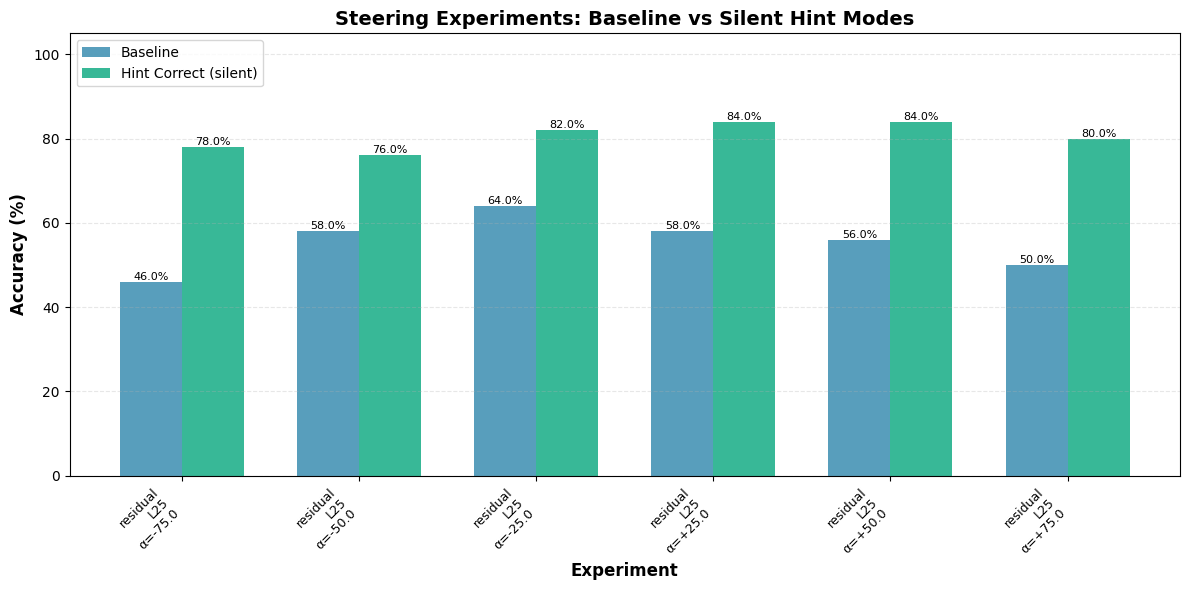

In [25]:
# ============================================================================
# VISUALIZATION: Baseline vs Silent Hint Modes
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

def visualize_performance(results):
    """Visualize baseline vs silent hint modes across all experiments"""
    exp_data = []
    exp_labels = []
    
    for location_type, layer_idx, alpha, output_file in results:
        data = []
        with open(output_file, "r") as f:
            for line in f:
                data.append(json.loads(line))
        df = pd.DataFrame(data)
        
        # Calculate accuracies
        baseline_df = df[df["mode"] == "baseline"]
        hint_correct_df = df[df["mode"] == "hint_correct_silent"]
        
        baseline_acc = baseline_df["is_correct"].sum() / len(baseline_df) * 100
        hint_correct_acc = hint_correct_df["is_correct"].sum() / len(hint_correct_df) * 100
        
        label = f"{location_type}\nL{layer_idx}\nα={alpha:+.1f}"
        
        exp_data.append({
            "baseline": baseline_acc,
            "hint_correct": hint_correct_acc,
        })
        exp_labels.append(label)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(max(12, len(results) * 0.8), 6))
    
    x = np.arange(len(exp_labels))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, [d["baseline"] for d in exp_data], width, 
                    label="Baseline", color="#2E86AB", alpha=0.8)
    bars2 = ax.bar(x + width/2, [d["hint_correct"] for d in exp_data], width,
                    label="Hint Correct (silent)", color="#06A77D", alpha=0.8)
    
    ax.set_xlabel("Experiment", fontsize=12, fontweight="bold")
    ax.set_ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
    ax.set_title("Steering Experiments: Baseline vs Silent Hint Modes", fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(exp_labels, rotation=45, ha="right", fontsize=9)
    ax.legend(loc="upper left", fontsize=10)
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.set_ylim([0, 105])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_performance(results)